In [1]:
# Configuration step (Please run it before the code!)

import numpy as np
import sys, obspy, os
import matplotlib.pyplot as plt

from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth as gps2DistAzimuth # depends on obspy version; this is for v1.1.0
#from obspy.core.util import gps2DistAzimuth

#from PIL import Image
import requests
from io import BytesIO

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 1. Read in noise data

In [2]:
# Shapiro et al. use noise data from MLAC and PHL stations

num_of_days = 90                            # no of days of data: change if more than 90days of data is required
if num_of_days <= 90:
    # get noise data for station MLAC
    stn = obspy.read('https://raw.github.com/ashimrijal/NoiseCorrelation/master/data/noise.CI.MLAC.LHZ.2004.294.2005.017.mseed')
    # get noise data for the station PHL and add it to the previous stream
    stn += obspy.read('https://raw.github.com/ashimrijal/NoiseCorrelation/master/data/noise.CI.PHL.LHZ.2004.294.2005.017.mseed')
    # if you have data stored locally, comment the stn = and stn += lines above
    # then uncomment the following 3 lines and adapt the path: 
    # stn = obspy.read('./noise.CI.MLAC.LHZ.2004.294.2005.017.mseed')
    # stn += obspy.read('noise.CI.PHL.LHZ.2004.294.2005.017.mseed')
    # ste = obspy.read('event.CI.PHL.LHZ.1998.196.1998.196.mseed')
else:
    # download data from IRIS database
    client = Client("IRIS")                               # client specification
    t1 = UTCDateTime("2004-10-20T00:00:00.230799Z")       # start UTC date/time
    t2 = t1+(num_of_days*86400)                           # end UTC date/time
    stn = client.get_waveforms(network="CI", station="MLAC",location="*", channel="*",
                               starttime=t1, endtime=t2)  # get data for MLAC
    stn += client.get_waveforms(network="CI", station="PHL", location="*", channel="*",
                                starttime=t1, endtime=t2) # get data for PHL and add it to the previous stream

## 2. Preprocess noise

### Preprocessing 1

In [3]:
# Preprocessing 1

stp = stn.copy()                                                 # copy stream
t = stp[0].stats.starttime
stp.trim(t, t + 4 * 86400)                                       # shorten stream for quicker processing

stp.detrend('linear')                                            # remove trends using detrend
stp.taper(max_percentage=0.05, type='cosine')                    # taper the edges
stp.filter('bandpass', freqmin=0.1, freqmax=0.2, zerophase=True) # filter data of all traces in the streams

10 Trace(s) in Stream:
CI.MLAC..LHZ | 2004-10-20T00:00:00.230799Z - 2004-10-21T00:00:00.230799Z | 1.0 Hz, 86401 samples
CI.MLAC..LHZ | 2004-10-21T00:00:00.230799Z - 2004-10-22T00:00:00.230799Z | 1.0 Hz, 86401 samples
CI.MLAC..LHZ | 2004-10-22T00:00:00.230799Z - 2004-10-23T00:00:00.230799Z | 1.0 Hz, 86401 samples
CI.MLAC..LHZ | 2004-10-23T00:00:00.230799Z - 2004-10-24T00:00:00.230799Z | 1.0 Hz, 86401 samples
CI.MLAC..LHZ | 2004-10-24T00:00:00.230799Z - 2004-10-24T00:00:00.230799Z | 1.0 Hz, 1 samples
CI.PHL..LHZ  | 2004-10-20T00:00:00.000000Z - 2004-10-21T00:00:00.000000Z | 1.0 Hz, 86401 samples
CI.PHL..LHZ  | 2004-10-21T00:00:00.000000Z - 2004-10-22T00:00:00.000000Z | 1.0 Hz, 86401 samples
CI.PHL..LHZ  | 2004-10-22T00:00:00.000000Z - 2004-10-23T00:00:00.000000Z | 1.0 Hz, 86401 samples
CI.PHL..LHZ  | 2004-10-23T00:00:00.000000Z - 2004-10-24T00:00:00.000000Z | 1.0 Hz, 86401 samples
CI.PHL..LHZ  | 2004-10-24T00:00:00.000000Z - 2004-10-24T00:00:00.000000Z | 1.0 Hz, 1 samples

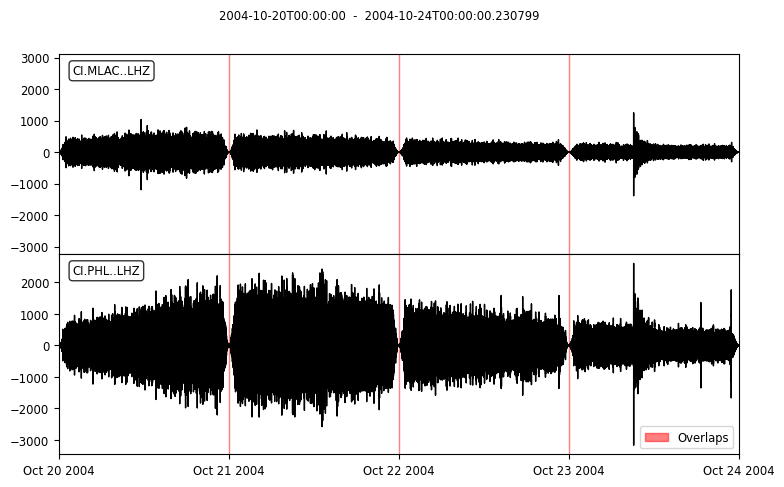

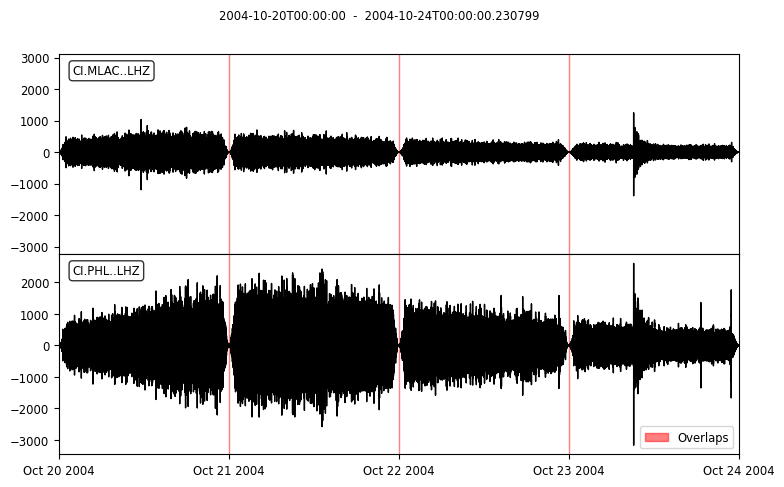

In [4]:
stp.plot()

### Preprocessing 2

In [5]:
# Functions
# collection of functions used in noise correlation processing

def normalize(tr, clip_factor=6, clip_weight=10, norm_win=None, norm_method="1bit"): 
    
    if norm_method == 'clipping':
        lim = clip_factor * np.std(tr.data)
        tr.data[tr.data > lim] = lim
        tr.data[tr.data < -lim] = -lim

    elif norm_method == "clipping_iter":
        lim = clip_factor * np.std(np.abs(tr.data))
        
        # as long as still values left above the waterlevel, clip_weight
        while tr.data[np.abs(tr.data) > lim] != []:
            tr.data[tr.data > lim] /= clip_weight
            tr.data[tr.data < -lim] /= clip_weight

    elif norm_method == 'ramn':
        lwin = tr.stats.sampling_rate * norm_win
        st = 0                                               # starting point
        N = lwin                                             # ending point

        while N < tr.stats.npts:
            win = tr.data[st:N]

            w = np.mean(np.abs(win)) / (2. * lwin + 1)
            
            # weight center of window
            tr.data[st + lwin / 2] /= w

            # shift window
            st += 1
            N += 1

        # taper edges
        taper = get_window(tr.stats.npts)
        tr.data *= taper

    elif norm_method == "1bit":
        tr.data = np.sign(tr.data)
        tr.data = np.float32(tr.data)

    return tr


def get_window(N, alpha=0.2):

    window = np.ones(N)
    x = np.linspace(-1., 1., N)
    ind1 = (abs(x) > 1 - alpha) * (x < 0)
    ind2 = (abs(x) > 1 - alpha) * (x > 0)
    window[ind1] = 0.5 * (1 - np.cos(np.pi * (x[ind1] + 1) / alpha))
    window[ind2] = 0.5 * (1 - np.cos(np.pi * (x[ind2] - 1) / alpha))
    return window


def whiten(tr, freqmin, freqmax):
    
    nsamp = tr.stats.sampling_rate
    
    n = len(tr.data)
    if n == 1:
        return tr
    else: 
        frange = float(freqmax) - float(freqmin)
        nsmo = int(np.fix(min(0.01, 0.5 * (frange)) * float(n) / nsamp))
        f = np.arange(n) * nsamp / (n - 1.)
        JJ = ((f > float(freqmin)) & (f<float(freqmax))).nonzero()[0]
            
        # signal FFT
        FFTs = np.fft.fft(tr.data)
        FFTsW = np.zeros(n) + 1j * np.zeros(n)

        # Apodization to the left with cos^2 (to smooth the discontinuities)
        smo1 = (np.cos(np.linspace(np.pi / 2, np.pi, nsmo+1))**2)
        FFTsW[JJ[0]:JJ[0]+nsmo+1] = smo1 * np.exp(1j * np.angle(FFTs[JJ[0]:JJ[0]+nsmo+1]))

        # boxcar
        FFTsW[JJ[0]+nsmo+1:JJ[-1]-nsmo] = np.ones(len(JJ) - 2 * (nsmo+1))\
        * np.exp(1j * np.angle(FFTs[JJ[0]+nsmo+1:JJ[-1]-nsmo]))

        # Apodization to the right with cos^2 (to smooth the discontinuities)
        smo2 = (np.cos(np.linspace(0, np.pi/2, nsmo+1))**2.)
        espo = np.exp(1j * np.angle(FFTs[JJ[-1]-nsmo:JJ[-1]+1]))
        FFTsW[JJ[-1]-nsmo:JJ[-1]+1] = smo2 * espo

        whitedata = 2. * np.fft.ifft(FFTsW).real
        
        tr.data = np.require(whitedata, dtype="float32")

        return tr


def correlateNoise(st, stations, corrwin):

    print ('correlating stations', (stations[0], stations[1]))

    # initialize sliding timewindow (length = corrwin) for correlation
    # start 1 corrwin after the start to account for different stream lengths
    timewin = st.select(station=stations[1])[0].stats.starttime + corrwin

    # loop over timewindows 
    # stop 1 corrwin before the end to account for different stream lengths
    while timewin < st.select(station=stations[0])[-1].stats.endtime - 2*corrwin:
        sig1 = st.select(station=stations[0]).slice(timewin, timewin+corrwin)
        sig1.merge(method=0, fill_value=0)
        sig2 = st.select(station=stations[1]).slice(timewin, timewin+corrwin)
        sig2.merge(method=0, fill_value=0)
        xcorr = np.correlate(sig1[0].data, sig2[0].data, 'same')

        try: 
            # build array with all correlations
            corr = np.vstack((corr, xcorr))
        except: 
            # if corr doesn't exist yet
            corr = xcorr
            
        # shift timewindow by one correlation window length
        timewin += corrwin

        # stack the correlations; normalize
        stack = np.sum(corr, 0)
        stack = stack / float((np.abs(stack).max()))    
    print ("...done")

    return corr, stack


def plotStack(st, stack, maxlag, figurename=None):

    # define the time vector for the correlation (length of corr = corrwin + 1)
    limit = (len(stack) / 2.) * st[0].stats.delta
    timevec = np.arange(-limit, limit, st[0].stats.delta)

    plt.plot(timevec, stack, 'k')
    stations = list(set([_i.stats.station for _i in st]))
    plt.title("Stacked correlation between %s and %s" % (stations[0], stations[1]))
    plt.xlim(-maxlag, maxlag)
    plt.xlabel('time [s]')

    if figurename is not None:
        fig.savefig(figurename, format="pdf")
    else:
        plt.show()
        
        
def plotXcorrEvent(st, stn, stack, maxlag, acausal=False, figurename=None):

    eventtime = UTCDateTime(1998,7,15,4,53,21,0)                 # event near MLAC

    # station locations
    latP, lonP = 35.41, -120.55                                  # station PHL
    latM, lonM = 37.63, -118.84                                  # station MLAC
    latE, lonE = 37.55, -118.809                                 # event 1998
    
    # calculate distance between stations
    dist = gps2DistAzimuth(latP, lonP, latM, lonM)[0]            # between PHL and MLAC
    distE = gps2DistAzimuth(latP, lonP, latE, lonE)[0]           # between event and PHL
                                                                 #
    # CROSSCORRELATION
    # reverse stack to plot acausal part (= negative times of correlation)
    if acausal:
        stack = stack[::-1]
    
    # find center of stack
    c = int(np.ceil(len(stack)/2.) + 1)
    
    #cut stack to maxlag
    stack = stack[c - maxlag * int(np.ceil(stn[0].stats.sampling_rate)) : c + maxlag * int(np.ceil(stn[0].stats.sampling_rate))]
    
    # find new center of stack
    c2 = int(np.ceil(len(stack)/2.) + 1)

    # define time vector for cross correlation
    limit = (len(stack) / 2.) * stn[0].stats.delta
    timevec = np.arange(-limit, limit, stn[0].stats.delta)
    # define timevector: dist / t
    timevecDist = dist / timevec
    
    # EVENT
    ste = st.copy()
    st_PHL_e = ste.select(station='PHL')
    
    # cut down event trace to 'maxlag' seconds
    dt = len(stack[c2:])/stn[0].stats.sampling_rate                  #xcorrlength
    st_PHL_e[0].trim(eventtime, eventtime + dt)
    
    # create time vector for event signal
    # extreme values:
    limit = st_PHL_e[0].stats.npts * st_PHL_e[0].stats.delta
    timevecSig = np.arange(0, limit, st_PHL_e[0].stats.delta)

    # PLOTTING
    fig = plt.figure(figsize=(12.0, 6.0))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)

    # plot noise correlation
    ax1.plot(timevecDist[c2:], stack[c2:], 'k')
    ax1.set_title('Noise correlation between MLAC and PHL')

    # plot event near MLAC measured at PHL
    ax2.plot(distE/timevecSig, st_PHL_e[0].data / np.max(np.abs(st_PHL_e[0].data)), 'r')
    ax2.set_title('Event near MLAC observed at PHL')

    ax2.set_xlim((0, 8000))
    ax1.set_xlim((0, 8000))

    ax2.set_xlabel("group velocity [m/s]")
 
    if figurename is not None:
        fig.savefig(figurename, format="pdf")
    else:
        plt.show()

In [6]:
# Preprocessing 2
st = stp.copy()                            # copy stream

for tr in st:
    tr = normalize(tr, norm_method="1bit")
    tr = whiten(tr, 0.1, 0.2)
print ('done!')

done!


## Cross-correlation

In [7]:
# Cross-correlate
xcorr, stack = correlateNoise(st, ['MLAC','PHL'], 7200)

correlating stations ('MLAC', 'PHL')
...done


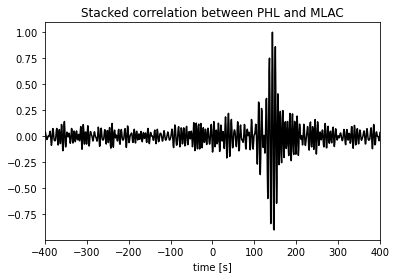

In [8]:
# Plotting

plotStack(st,stack,400)

## Compare the cross-correlation result to the event trace

In [9]:
ste = obspy.read('https://raw.github.com/ashimrijal/NoiseCorrelation/master/data/event.CI.PHL.LHZ.1998.196.1998.196.mseed')
# if data is stored locally, uncomment the following line and comment the line above:
#ste = obspy.read('./event.CI.PHL.LHZ.1998.196.1998.196.mseed')

# Preprocessing
ste.detrend('linear')
ste.filter('bandpass', freqmin=0.1, freqmax=0.2, zerophase=True)
for tr in ste:
    tr = whiten(tr, 0.1, 0.2)

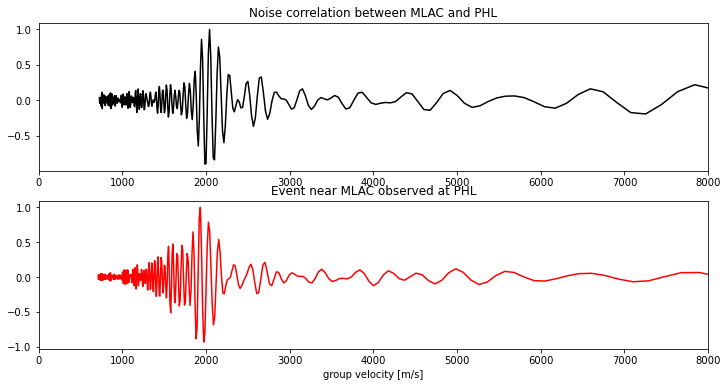

In [10]:
# Plotting

plotXcorrEvent(ste, stn, stack, 400)